In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

warnings.filterwarnings("ignore")
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["axes.grid"] = False

In [3]:
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
country.tail()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe
2013-07-01,17.000,0.453,Zimbabwe
2013-08-01,19.759,0.717,Zimbabwe
2013-09-01,NaN,NaN,Zimbabwe


,AverageTemperature
dt,
1825-01-01,25.552167
1826-01-01,25.365000
1827-01-01,25.365000
1828-01-01,25.365000
1829-01-01,25.365000
...,...
2009-01-01,26.455000
2010-01-01,26.537000
2011-01-01,26.202250


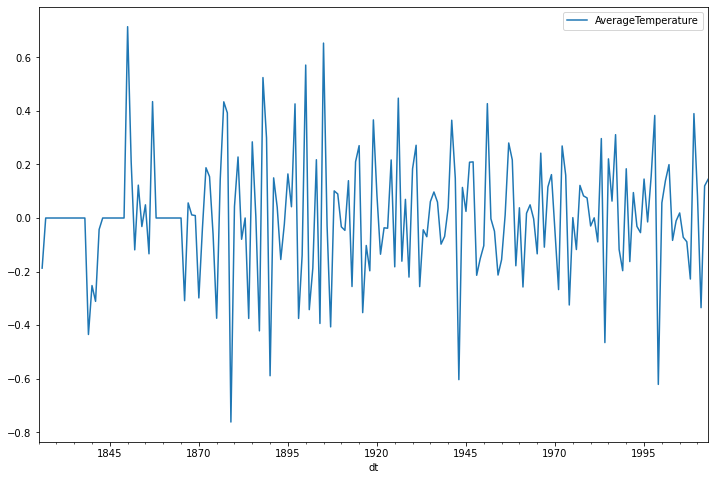

In [4]:
# filtering the dataframe to show only Indonesia
indo = country.copy()
indo = indo.loc[indo["Country"] == "Indonesia"]
indo.fillna(method='bfill', inplace=True)

# resampling the data to show the average temp of each decade
filtered = indo.resample("AS").mean()
filtered.drop("AverageTemperatureUncertainty", axis=1, inplace=True)

# first order of differentials
filtered.diff().plot(figsize=(12,8))
filtered

In [5]:
# checking the stationarity of the time series using Augmented Dicky-Fuller test
# finding the p value to proceed with differencing
# since p-value is larger than chosen threshold (5%), time series is not stationary
result = adfuller(filtered.AverageTemperature)
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])

ADF Statistic: -1.155791
p-value: 0.692318


In [6]:
# splitting the dataset into train, validation, and test dataset
# using 75:15:10 ratio
n = len(filtered)
train, validation, test = filtered[0:int(n*0.75)], filtered[int(n*0.75):int(n*0.9)], filtered[int(n*0.9):]

In [7]:
def optimize_SARIMAX(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
# checking the best ARIMA model
ps = range(0, 8, 1)
d = range(0, 8, 1)
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_SARIMAX(order_list, filtered)

results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(3, 1, 3)",-53.197321
1,"(4, 1, 4)",-52.604224
2,"(2, 1, 5)",-52.306495
3,"(2, 1, 4)",-52.066127
4,"(1, 1, 6)",-51.855008
...,...,...
59,"(1, 1, 1)",-44.995684
60,"(7, 1, 1)",-44.495703
61,"(0, 1, 1)",-42.464607
62,"(1, 1, 0)",-28.900607


In [20]:
# according to the test above, the best model is the 313 model
model = SARIMAX(filtered, order=(3,1,3), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   AverageTemperature   No. Observations:                  189
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                  11.283
Date:                              Thu, 13 Jan 2022   AIC                             -4.566
Time:                                      08:50:46   BIC                             23.968
Sample:                                  01-01-1825   HQIC                             7.007
                                       - 01-01-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1141      0.288     -0.397      0.692      -0.678       0.450
ar.L2          0.2310      0.236      0.980      0.327      -0.231       0.693
ar.L3         -0.3985      0.135     -2.958      0.003      -0.662      -0.134
ma.L1         -0.2089      0.303     -0.690      0.490      -0.802       0.385
ma.L2         -0.5699      0.155     -3.668      0.000      -0.874      -0.265
ma.L3          0.5796      0.179      3.240      0.001       0.229       0.930
ar.S.L12      -0.0008      0.110     -0.007      0.994      -0.216       0.214
ma.S.L12      -0.9841      1.034     -0.952      0.341      -3.010       1.042
sigma2         0.0426      0.042      1.007      0.314      -0.040       0.126
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.94   Prob(JB):                         0.10
Heteroskedasticity (H):               0.60   Skew:                             0.37
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

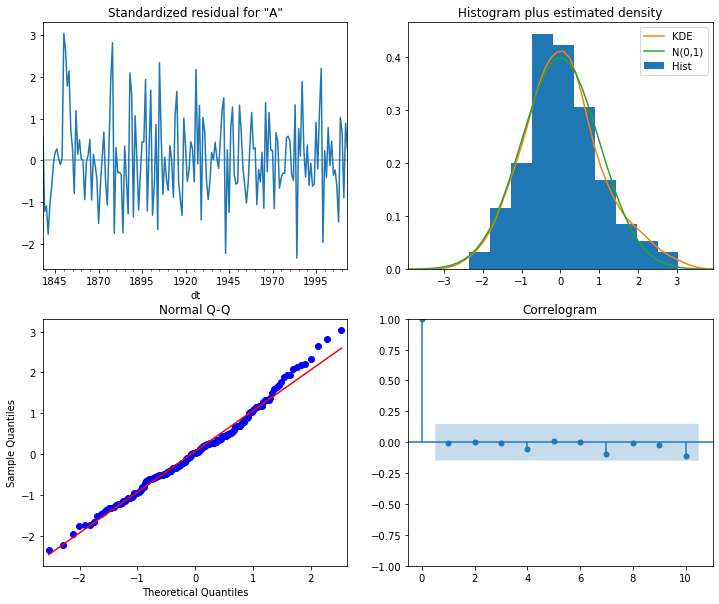

In [15]:
# residuals plot
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

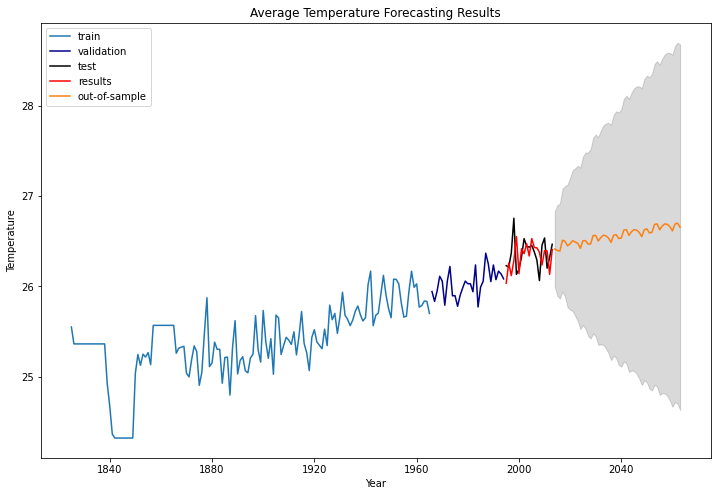

In [21]:
# plotting the in-sample prediction
results = model_fit.predict(start=int(n*0.9))
forecast = model_fit.get_forecast(steps=50)
conf_int = forecast.conf_int(alpha=0.05)
out_of_sample = forecast.predicted_mean

# confidence intervals
lower_bound = pd.Series(conf_int.iloc[:,0])
upper_bound = pd.Series(conf_int.iloc[:,1])

plt.figure(figsize=(12, 8))
plt.plot(train, label="train")
plt.plot(validation, label="validation", color="darkblue")
plt.plot(test, label="test", color="black")
plt.plot(results, label="results", color="red")
plt.plot(out_of_sample, label="out-of-sample")
plt.fill_between(lower_bound.index, lower_bound, upper_bound, color="k", alpha=.15)
plt.title("Average Temperature Forecasting Results")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend(loc="upper left")
plt.show()

In [18]:
# regression analysis
def pred_accuracy(prediction, actual):
    mae = np.mean(np.abs(prediction-actual))
    mape = np.mean(np.abs(prediction-actual) / np.abs(actual))
    mpe = np.mean((prediction-actual)/actual)
    rmse = np.mean((prediction - actual)**2)**0.5
    return {"MAPE" : mape, "MPE" : mpe, "MAE" : mae, "RMSE" : rmse}

pred_accuracy(results.values, test.values)

{'MAPE': 0.006499062015946482,
 'MPE': -0.0009344716344135506,
 'MAE': 0.1714236406482904,
 'RMSE': 0.2153531822680051}

[26.41526302568091, 26.398218972537453, 26.391985462520868, 26.511587426931783, 26.49933135252922, 26.44908539630236, 26.472844713348632, 26.507955367564385, 26.4910189344434, 26.477047765153472, 26.42162360522786, 26.506241139636924, 26.507629583123123, 26.469090255015804, 26.470472890090416, 26.56308252128664, 26.56415687654088, 26.503101988808588, 26.54171215554017, 26.567559147410744, 26.559557519894188, 26.536130557926054, 26.487738638380737, 26.565958607783777, 26.57330404279503, 26.52986000263251, 26.535751543175444, 26.624340022508118, 26.62886918539252, 26.564694571355716, 26.606061237369108, 26.629496234919984, 26.623649575754975, 26.598321470196204, 26.551605223180832, 26.62833602912863, 26.636996134155396, 26.59239034602345, 26.59931149917737, 26.686990279397502, 26.692324001026748, 26.627437176647234, 26.669433446567776, 26.692311493401874, 26.686957615317816, 26.66119374936198, 26.61486298327139, 26.6912527868318, 26.700214483647233, 26.65534190981249]


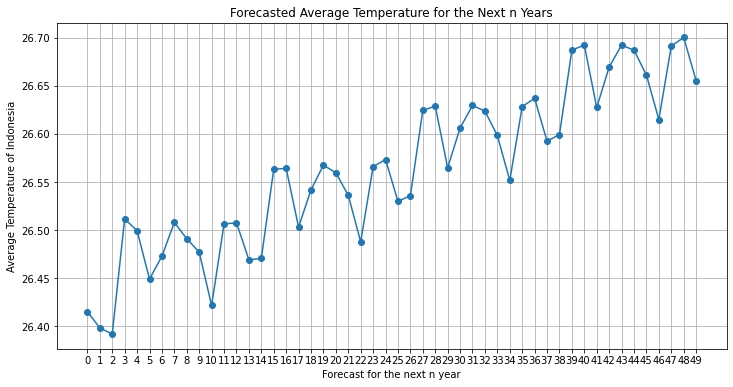

In [19]:
forecast = model_fit.forecast(steps=50)
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("Forecast for the next n year")
plt.ylabel("Average Temperature of Indonesia")
plt.title("Forecasted Average Temperature for the Next n Years")
plt.grid()
print(forecast_values)